In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils.validation import check_X_y, check_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from tensorflow import keras
from keras.layers import Input, Dense, Dropout

In [2]:
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.transformers import NeuralRegressionTransformer
from proglearn.voters import NeuralRegressionVoter
from proglearn.deciders import KNNRegressionDecider, NeuralRegressionDecider

This notebook test the progressive learning regression methodology on a few toy multitasks with known outcomes, to see if it can successfully learn and share representations. In all cases, three tasks are presented. Each are regression of a single real-valued response on a real-valued, $d$ dimensional vector. In all cases, the vector will be scaled, have some known transformation applied to it (common for all tasks), and then another vote-decision function that maps it to the output (which differs for each task). The following three multitask then differ on the following five parameters: how the input is sampled, which common transformer, and which vote-decision to use for each of the three subtasks.

In [3]:
# n is the per-task sample size.
def generate_data(n, d, transform, vote, sigma = 1):
    X = np.random.randn(n, d)
    y = vote(transform(X)) + np.random.normal(loc=0.0, scale=sigma, size=n)
    
    return X, y

def plot_data(data):
    sns.set(font_scale = 1.5)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    fig, ax = plt.subplots(1, 1, figsize = (5,4))
    
    colors = ["#c51b7d", "#2166ac", "#d95f02"]
    
    for (X, y), color in zip(data, colors):
        if X.shape[1] != 1:
            raise ValueError("X must be one-dimensional to plot.")
        
        ax.scatter(X, y, color = color, marker = ".")    
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = check_array(y_true, ensure_2d=False), check_array(y_pred, ensure_2d=False)
    return np.mean(np.abs((y_true - y_pred) / y_true))

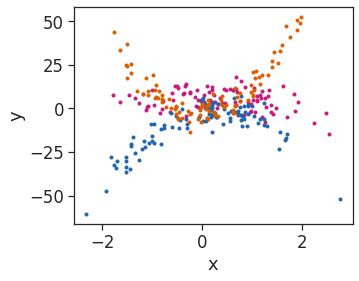

In [4]:
n = 100
d = 1

rep_dim = 29
W = np.random.randn(rep_dim, d)
b = np.random.randn(rep_dim)
v1 = np.random.randn(rep_dim)
v2 = np.random.randn(rep_dim)
v3 = np.random.randn(rep_dim)
vs = [v1, v2, v3]

data = []
for v in vs:
    data.append(generate_data(n, d, lambda X: np.square(np.dot(X, W.T) + b), lambda X: np.dot(X, v), sigma = 5))

plot_data(data)

In [5]:
# Generate a PL that has a neural transformer, a neural voter (with one output unit), and a KNN decider.
def build_predictive_ensembler(d, verbose_transform = False, verbose_vote = False):    
    
    default_transformer_class = NeuralRegressionTransformer
        
    # Representation
    network = keras.Sequential()
    network.add(Input(shape=(d,), name = 'input'))
    network.add(Dense(16, activation='relu', name = 'fc0'))
    network.add(Dense(4, activation='relu', name = 'fc1')) 
    
    # Output layer.
    network.add(Dense(1, activation = 'linear', name = 'output'))

    default_transformer_kwargs = {"network" : network, 
                                  "euclidean_layer_idx" : -2,
                                  "loss" : "mae",
                                  "optimizer" : keras.optimizers.Adam(1e-2),
                                  "fit_kwargs" : {"epochs" : 100, "verbose" : verbose_transform}
                                 }

    default_voter_class = NeuralRegressionVoter
    default_voter_kwargs = {"loss" : "mae",
                            "verbose" : verbose_vote,
                            "epochs" : 100,
                            "lr" : 1e-2
                           }
    default_decider_class = KNNRegressionDecider
    
    return ProgressiveLearner(default_transformer_class = default_transformer_class, 
                              default_transformer_kwargs = default_transformer_kwargs,
                              default_voter_class = default_voter_class,
                              default_voter_kwargs = default_voter_kwargs, 
                              default_decider_class = default_decider_class,
                              default_decider_kwargs = {})

In [8]:
# Generate a PL that has a neural transformer, a neural voter (with one output unit), and a KNN decider.
def build_representation_ensembler(d, num_tasks = 3, verbose_transform = False, verbose_decide = False):
    
    default_transformer_class = NeuralRegressionTransformer
    
    backbone_layer_size = 4 # second to last layer in each transformer and the full decider.
        
    # Representation
    transform_network = keras.Sequential()
    transform_network.add(Input(shape=(d,), name = 'input'))
    transform_network.add(Dense(16, activation='relu', name = 'fc0'))
    transform_network.add(Dense(backbone_layer_size, activation='relu', name = 'fc1')) 
    
    # Output layer.
    transform_network.add(Dense(1, activation = 'linear', name = 'output2'))

    default_transformer_kwargs = {"network" : transform_network, 
                                  "euclidean_layer_idx" : -2,
                                  "loss" : "mae",
                                  "optimizer" : keras.optimizers.Adam(3e-2),
                                  "fit_kwargs" : {"epochs" : 100, "verbose" : verbose_transform}
                                 }

    # Unused in this model.
    default_voter_class = NeuralRegressionVoter
    default_voter_kwargs = {}
    
    default_decider_class = NeuralRegressionDecider
    
    def build_decider_network(input_shape):
    
        decide_network = keras.Sequential()
        decide_network.add(Input(shape=(input_shape), name = 'concatenated_input3'))
        decide_network.add(Dropout(0.3, name = 'd4'))
        decide_network.add(Dense(backbone_layer_size, activation='relu', name = 'fc5'))

        # Output layer.
        decide_network.add(Dense(1, activation = 'linear', name = 'output6'))
        
        return decide_network
    
    default_decider_kwargs = {"build_network" : build_decider_network,
                              "backbone_layer_size" : backbone_layer_size,
                              "loss" : "mae",
                              "optimizer" : keras.optimizers.Adam(3e-2),
                              "fit_kwargs" : {"epochs" : 100, "verbose" : verbose_decide}
                             }
    
    return ProgressiveLearner(default_transformer_class = default_transformer_class, 
                              default_transformer_kwargs = default_transformer_kwargs,
                              default_voter_class = default_voter_class,
                              default_voter_kwargs = default_voter_kwargs, 
                              default_decider_class = default_decider_class,
                              default_decider_kwargs = default_decider_kwargs)

# Check 1
In this task, we transform by applying a random linear transform followed by an element-wise square. We vote by a random linear combination and add noise. Here, we just wish to show that the Progressive Learner is a single-task learner, in that it can learn one task.

In [9]:
n_train = 10000
n_test = 1000
d = 10

np.random.seed(1)
rep_dim = 4 # The matrix will be invertible with high probabability.
W = (1 / d) * np.random.randn(rep_dim, d)
b = np.random.randn(rep_dim)
v = np.random.randn(rep_dim)

# We will do no noise to see that it can fit a deterministic function.
X, y = generate_data(n_train + n_test, d, lambda X: np.square(np.dot(X, W.T) + b), lambda X: np.dot(X, v), sigma = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test, random_state=42)

In [10]:
# Initialize prog. learner and populate with one task.
pl = build_representation_ensembler(d, num_tasks = 1, verbose_decide = False)
pl.add_task(X = X_train, y = y_train, task_id = 0, transformer_voter_decider_split = [0.6, 0.2, 0.2])

(2000, 4)


In [11]:
# Predict on this task.
y_pred = pl.predict(X_test, task_id = 0)
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Single, deterministic task (n = %d and d = %d):" % (n_train, d))
print("MAPE =", mape)
print("MAE =", mae)

(1000, 4)
Single, deterministic task (n = 10000 and d = 10):
MAPE = 0.3726565602683643
MAE = 0.9970949814573637


# Check 2
In this task, we transform by applying a random linear transform followed by an element-wise square. We vote by a random linear combination and add noise for 3 separate tasks. We train an honest learner on just one task with less data, and a progressive learner with data from all 3 tasks. We wish to show that when all three tasks have the same transformer, the progressive learner wins.

In [12]:
n_train_small = 100
n_train_large = 3000
n_test = 1000
sigma = 1
d = 10

np.random.seed(2)

# We'll use the same (true) transformer for all three tasks, but different voters.
rep_dim = 10 # The matrix will be invertible with high probabability.
W = (1 / d) * np.random.randn(rep_dim, d)
b = np.random.randn(rep_dim)
def transform(X):
    return np.square(np.dot(X, W.T) + b)
def vote_with(v):
    return lambda X: np.dot(X, v)
data = []

# Task 0.
v0 = np.random.randn(rep_dim)
X, y = generate_data(n_train_small + n_test, d, transform, vote_with(v0), sigma = sigma)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test)
data.append((X_train, y_train))

# Task 1.
v1 = np.random.randn(rep_dim)
X, y = generate_data(n_train_large, d, transform, vote_with(v1), sigma = sigma)
data.append((X, y))

# Task 2.
v2 = np.random.randn(rep_dim)
X, y = generate_data(n_train_large, d, transform, vote_with(v2), sigma = sigma)
data.append((X, y))

In [13]:
# Single-task Honest Learner
pl_single = build_predictive_ensembler(d, verbose_transform = False, verbose_vote = False)
X, y = data[0]
pl_single.add_task(X = X, y = y, task_id = 0, transformer_voter_decider_split = [0.6, 0.2, 0.2])

In [14]:
# Multitask Learner (predictions)
pl_pred = build_predictive_ensembler(d, verbose_transform = False, verbose_vote = False)
for j in range(3):
    print("Fitting task", j)
    X, y = data[j]
    pl_pred.add_task(X = X, y = y, task_id = j, transformer_voter_decider_split = [0.6, 0.2, 0.2])

Fitting task 0
Fitting task 1
Fitting task 2


In [15]:
# Multitask Learner (representations)
pl_rep = build_representation_ensembler(d, num_tasks = 3, verbose_transform = False, verbose_decide = True)
for j in range(3):
    print("Fitting task", j)
    X, y = data[j]
    pl_rep.add_task(X = X, y = y, task_id = j, transformer_voter_decider_split = [0.6, 0.2, 0.2])

Fitting task 0
(20, 4)
Epoch 1/100
1/1 [==============================] - 0s 1ms/step - loss: 5.4268 - MAPE: 75.7965 - MAE: 5.4268
Epoch 2/100
1/1 [==============================] - 0s 906us/step - loss: 5.2518 - MAPE: 73.4735 - MAE: 5.2518
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 5.1701 - MAPE: 72.5802 - MAE: 5.1701
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 4.7600 - MAPE: 65.9916 - MAE: 4.7600
Epoch 5/100
1/1 [==============================] - 0s 732us/step - loss: 3.7894 - MAPE: 53.4912 - MAE: 3.7894
Epoch 6/100
1/1 [==============================] - 0s 857us/step - loss: 3.6880 - MAPE: 50.8277 - MAE: 3.6880
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 3.2723 - MAPE: 45.8655 - MAE: 3.2723
Epoch 8/100
1/1 [==============================] - 0s 800us/step - loss: 3.2445 - MAPE: 45.0588 - MAE: 3.2445
Epoch 9/100
1/1 [==============================] - 0s 912us/step - loss: 3.2333 - MAPE: 43.5622 - MAE: 3.

1/1 [==============================] - 0s 1ms/step - loss: 0.6297 - MAPE: 8.7118 - MAE: 0.6297
Epoch 76/100
1/1 [==============================] - 0s 965us/step - loss: 0.7295 - MAPE: 10.2956 - MAE: 0.7295
Epoch 77/100
1/1 [==============================] - 0s 2ms/step - loss: 0.6529 - MAPE: 8.8827 - MAE: 0.6529
Epoch 78/100
1/1 [==============================] - 0s 1ms/step - loss: 0.7011 - MAPE: 9.7122 - MAE: 0.7011
Epoch 79/100
1/1 [==============================] - 0s 1ms/step - loss: 0.6450 - MAPE: 8.8341 - MAE: 0.6450
Epoch 80/100
1/1 [==============================] - 0s 1ms/step - loss: 0.6777 - MAPE: 9.5851 - MAE: 0.6777
Epoch 81/100
1/1 [==============================] - 0s 2ms/step - loss: 0.6688 - MAPE: 9.3389 - MAE: 0.6688
Epoch 82/100
1/1 [==============================] - 0s 2ms/step - loss: 0.7348 - MAPE: 10.1158 - MAE: 0.7348
Epoch 83/100
1/1 [==============================] - 0s 1ms/step - loss: 0.6990 - MAPE: 9.9400 - MAE: 0.6990
Epoch 84/100
1/1 [===================

1/1 [==============================] - 0s 944us/step - loss: 1.2505 - MAPE: 16.3053 - MAE: 1.2505
Epoch 50/100
1/1 [==============================] - 0s 999us/step - loss: 1.0338 - MAPE: 13.9099 - MAE: 1.0338
Epoch 51/100
1/1 [==============================] - 0s 1ms/step - loss: 1.1315 - MAPE: 16.0500 - MAE: 1.1315
Epoch 52/100
1/1 [==============================] - 0s 1ms/step - loss: 1.0762 - MAPE: 14.3870 - MAE: 1.0762
Epoch 53/100
1/1 [==============================] - 0s 2ms/step - loss: 0.9587 - MAPE: 12.3456 - MAE: 0.9587
Epoch 54/100
1/1 [==============================] - 0s 2ms/step - loss: 1.0871 - MAPE: 14.8670 - MAE: 1.0871
Epoch 55/100
1/1 [==============================] - 0s 1ms/step - loss: 0.9271 - MAPE: 12.8180 - MAE: 0.9271
Epoch 56/100
1/1 [==============================] - 0s 1ms/step - loss: 0.8562 - MAPE: 11.4227 - MAE: 0.8562
Epoch 57/100
1/1 [==============================] - 0s 1ms/step - loss: 1.0976 - MAPE: 15.4068 - MAE: 1.0976
Epoch 58/100
1/1 [==========

19/19 [==============================] - 0s 1ms/step - loss: 1.0785 - MAPE: 109.8820 - MAE: 1.0785
Epoch 24/100
19/19 [==============================] - 0s 1ms/step - loss: 1.1254 - MAPE: 85.8822 - MAE: 1.1254
Epoch 25/100
19/19 [==============================] - 0s 1ms/step - loss: 1.0769 - MAPE: 85.1962 - MAE: 1.0769
Epoch 26/100
19/19 [==============================] - 0s 975us/step - loss: 1.0798 - MAPE: 82.9061 - MAE: 1.0798
Epoch 27/100
19/19 [==============================] - 0s 955us/step - loss: 1.1104 - MAPE: 87.4603 - MAE: 1.1104
Epoch 28/100
19/19 [==============================] - 0s 959us/step - loss: 1.1204 - MAPE: 109.6180 - MAE: 1.1204
Epoch 29/100
19/19 [==============================] - 0s 960us/step - loss: 1.1301 - MAPE: 90.6731 - MAE: 1.1301
Epoch 30/100
19/19 [==============================] - 0s 960us/step - loss: 1.1288 - MAPE: 88.1113 - MAE: 1.1288
Epoch 31/100
19/19 [==============================] - 0s 1ms/step - loss: 1.0995 - MAPE: 96.3784 - MAE: 1.0995
Ep

Epoch 96/100
19/19 [==============================] - 0s 1ms/step - loss: 1.0518 - MAPE: 87.5266 - MAE: 1.0518
Epoch 97/100
19/19 [==============================] - 0s 986us/step - loss: 1.0778 - MAPE: 104.8108 - MAE: 1.0778
Epoch 98/100
19/19 [==============================] - 0s 977us/step - loss: 1.1123 - MAPE: 83.5336 - MAE: 1.1123
Epoch 99/100
19/19 [==============================] - 0s 1ms/step - loss: 1.0775 - MAPE: 82.5497 - MAE: 1.0775
Epoch 100/100
19/19 [==============================] - 0s 937us/step - loss: 1.0198 - MAPE: 90.3968 - MAE: 1.0198
Fitting task 2
(20, 12)
Epoch 1/100
1/1 [==============================] - 0s 1ms/step - loss: 4.3115 - MAPE: 58.2155 - MAE: 4.3115
Epoch 2/100
1/1 [==============================] - 0s 856us/step - loss: 3.9135 - MAPE: 57.1985 - MAE: 3.9135
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 3.9583 - MAPE: 55.9025 - MAE: 3.9583
Epoch 4/100
1/1 [==============================] - 0s 978us/step - loss: 3.4217 - MAPE:

1/1 [==============================] - 0s 1ms/step - loss: 0.9211 - MAPE: 12.6409 - MAE: 0.9211
Epoch 71/100
1/1 [==============================] - 0s 898us/step - loss: 1.1485 - MAPE: 15.8541 - MAE: 1.1485
Epoch 72/100
1/1 [==============================] - 0s 976us/step - loss: 0.9736 - MAPE: 12.6418 - MAE: 0.9736
Epoch 73/100
1/1 [==============================] - 0s 1ms/step - loss: 1.2558 - MAPE: 16.6958 - MAE: 1.2558
Epoch 74/100
1/1 [==============================] - 0s 1ms/step - loss: 0.8942 - MAPE: 12.4155 - MAE: 0.8942
Epoch 75/100
1/1 [==============================] - 0s 2ms/step - loss: 0.8243 - MAPE: 12.6217 - MAE: 0.8243
Epoch 76/100
1/1 [==============================] - 0s 1ms/step - loss: 1.0680 - MAPE: 14.7111 - MAE: 1.0680
Epoch 77/100
1/1 [==============================] - 0s 1ms/step - loss: 1.1098 - MAPE: 15.6727 - MAE: 1.1098
Epoch 78/100
1/1 [==============================] - 0s 1ms/step - loss: 1.1408 - MAPE: 16.2594 - MAE: 1.1408
Epoch 79/100
1/1 [==========

19/19 [==============================] - 0s 1ms/step - loss: 1.9635 - MAPE: 198.3626 - MAE: 1.9635
Epoch 44/100
19/19 [==============================] - 0s 983us/step - loss: 1.9633 - MAPE: 198.5165 - MAE: 1.9633
Epoch 45/100
19/19 [==============================] - 0s 928us/step - loss: 1.9626 - MAPE: 198.0980 - MAE: 1.9626
Epoch 46/100
19/19 [==============================] - 0s 997us/step - loss: 1.9623 - MAPE: 197.0692 - MAE: 1.9623
Epoch 47/100
19/19 [==============================] - 0s 1ms/step - loss: 1.9642 - MAPE: 198.1107 - MAE: 1.9642
Epoch 48/100
19/19 [==============================] - 0s 941us/step - loss: 1.9603 - MAPE: 197.2100 - MAE: 1.9603
Epoch 49/100
19/19 [==============================] - 0s 965us/step - loss: 1.9621 - MAPE: 198.6005 - MAE: 1.9621
Epoch 50/100
19/19 [==============================] - 0s 985us/step - loss: 1.9630 - MAPE: 199.5551 - MAE: 1.9630
Epoch 51/100
19/19 [==============================] - 0s 987us/step - loss: 1.9621 - MAPE: 197.9177 - MAE

19/19 [==============================] - 0s 1ms/step - loss: 1.1688 - MAPE: 12.0672 - MAE: 1.1688
Epoch 16/100
19/19 [==============================] - 0s 1ms/step - loss: 1.2179 - MAPE: 12.3591 - MAE: 1.2179
Epoch 17/100
19/19 [==============================] - 0s 1ms/step - loss: 1.2379 - MAPE: 12.4876 - MAE: 1.2379
Epoch 18/100
19/19 [==============================] - 0s 2ms/step - loss: 1.4009 - MAPE: 14.1020 - MAE: 1.4009
Epoch 19/100
19/19 [==============================] - 0s 1ms/step - loss: 1.3094 - MAPE: 13.2427 - MAE: 1.3094
Epoch 20/100
19/19 [==============================] - 0s 1ms/step - loss: 1.1905 - MAPE: 12.2401 - MAE: 1.1905
Epoch 21/100
19/19 [==============================] - 0s 1ms/step - loss: 1.1833 - MAPE: 12.1396 - MAE: 1.1833
Epoch 22/100
19/19 [==============================] - 0s 1ms/step - loss: 1.1759 - MAPE: 11.9787 - MAE: 1.1759
Epoch 23/100
19/19 [==============================] - 0s 1ms/step - loss: 1.2695 - MAPE: 12.7954 - MAE: 1.2695
Epoch 24/100
1

19/19 [==============================] - 0s 1ms/step - loss: 1.1434 - MAPE: 11.8871 - MAE: 1.1434
Epoch 89/100
19/19 [==============================] - 0s 1ms/step - loss: 1.0777 - MAPE: 11.3524 - MAE: 1.0777
Epoch 90/100
19/19 [==============================] - 0s 1ms/step - loss: 1.0625 - MAPE: 11.1526 - MAE: 1.0625
Epoch 91/100
19/19 [==============================] - 0s 1ms/step - loss: 1.1448 - MAPE: 11.7476 - MAE: 1.1448
Epoch 92/100
19/19 [==============================] - 0s 1ms/step - loss: 1.0772 - MAPE: 11.3359 - MAE: 1.0772
Epoch 93/100
19/19 [==============================] - 0s 1ms/step - loss: 1.1497 - MAPE: 12.0063 - MAE: 1.1497
Epoch 94/100
19/19 [==============================] - 0s 1ms/step - loss: 1.1836 - MAPE: 12.2200 - MAE: 1.1836
Epoch 95/100
19/19 [==============================] - 0s 1ms/step - loss: 1.1060 - MAPE: 11.3580 - MAE: 1.1060
Epoch 96/100
19/19 [==============================] - 0s 1ms/step - loss: 1.0978 - MAPE: 11.4546 - MAE: 1.0978
Epoch 97/100
1

In [16]:
# Single task
y_pred_single = pl_single.predict(X_test, task_id = 0)
mae_single = mean_absolute_error(y_test, y_pred_single)
mape_single = mean_absolute_percentage_error(y_test, y_pred_single)

# Prediction Ensembler
y_pred = pl_pred.predict(X_test, task_id = 0)
mae_pred = mean_absolute_error(y_test, y_pred)
mape_pred = mean_absolute_percentage_error(y_test, y_pred)

# Representation Ensembler
y_pred = pl_rep.predict(X_test, task_id = 0)
mae_rep = mean_absolute_error(y_test, y_pred)
mape_rep = mean_absolute_percentage_error(y_test, y_pred)

print("Three tasks with a shared transformer:")
print("Training size for Task 0:", n_train_small)
print("Training size for Tasks 1 and 2:", n_train_large)
print("Dimensionality:", d)
print("Noise (var of y | x):", sigma)
print("MAE/MAPE on Task 0 of single-task honest learner:", mae_single, mape_single)
print("MAE/MAPE on Task 0 of (predictive) progressive learner:", mae_pred, mape_pred)
print("MAE/MAPE (predictive) Transfer Efficiency:", mae_single / mae_pred, mape_single / mape_pred)
print("MAE/MAPE on Task 0 of (representation) progressive learner:", mae_rep, mape_rep)
print("MAE/MAPE (representation) Transfer Efficiency:", mae_single / mae_rep, mape_single / mape_rep)

(1000, 12)
Three tasks with a shared transformer:
Training size for Task 0: 100
Training size for Tasks 1 and 2: 3000
Dimensionality: 10
Noise (var of y | x): 1
MAE/MAPE on Task 0 of single-task honest learner: 1.2987734999583722 0.1912881930150655
MAE/MAPE on Task 0 of (predictive) progressive learner: 1.2165589916298616 0.172439797103729
MAE/MAPE (predictive) Transfer Efficiency: 1.0675795492813425 1.1093042106747462
MAE/MAPE on Task 0 of (representation) progressive learner: 1.1586074751871602 0.17291507042470539
MAE/MAPE (representation) Transfer Efficiency: 1.1209780083186238 1.10625518380343


# Check 3
In this task, we try to show a case in which concatenating representations might work well.

In [17]:
n_train_small = 50
n_train_large = 2000
n_test = 1000
sigma = 1
d = 10

np.random.seed(3)

# We'll use 2 transformers for task 1 and 2, and combine them for task 0.
rep_dim = 10 # The matrix will be invertible with high probabability.
W1 = (1 / d) * np.random.randn(rep_dim, d)
b1 = np.random.randn(rep_dim)
W2 = (1 / d) * np.random.randn(rep_dim, d)
b2 = np.random.randn(rep_dim)
v = np.random.randn(rep_dim)
def transform1(X):
    return np.square(np.dot(X, W1.T) + b2)
def transform2(X):
    return np.tanh(np.dot(X, W2.T) + b2)
def transform0(X):
    return 0.5*transform1(X) + 0.5*transform2(X)
def vote(X):
    return np.dot(X, v)
data = []

# Task 0.
X, y = generate_data(n_train_small + n_test, d, transform0, vote, sigma = sigma)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test)
data.append((X_train, y_train))

# Task 1.
X, y = generate_data(n_train_large, d, transform1, vote, sigma = sigma)
data.append((X, y))

# Task 2.
X, y = generate_data(n_train_large, d, transform2, vote, sigma = sigma)
data.append((X, y))

In [19]:
# Single-task Honest Learner
pl_single = build_predictive_ensembler(d, verbose_transform = False, verbose_vote = False)
X, y = data[0]
pl_single.add_task(X = X, y = y, task_id = 0, transformer_voter_decider_split = [0.6, 0.2, 0.2])

In [20]:
# Multitask Learner (predictions)
pl_pred = build_predictive_ensembler(d, verbose_transform = False, verbose_vote = False)
for j in range(3):
    print("Fitting task", j)
    X, y = data[j]
    pl_pred.add_task(X = X, y = y, task_id = j, transformer_voter_decider_split = [0.6, 0.2, 0.2])

Fitting task 0
Fitting task 1
Fitting task 2


In [21]:
# Multitask Learner (representations)
pl_rep = build_representation_ensembler(d, num_tasks = 3, verbose_transform = False, verbose_decide = True)
for j in range(3):
    print("Fitting task", j)
    X, y = data[j]
    pl_rep.add_task(X = X, y = y, task_id = j, transformer_voter_decider_split = [0.6, 0.2, 0.2])

Fitting task 0
(10, 4)
Epoch 1/100
1/1 [==============================] - 0s 1ms/step - loss: 1.4941 - MAPE: 129.0983 - MAE: 1.4941
Epoch 2/100
1/1 [==============================] - 0s 850us/step - loss: 1.3985 - MAPE: 142.2330 - MAE: 1.3985
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 1.1953 - MAPE: 94.2977 - MAE: 1.1953
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 1.1228 - MAPE: 106.4033 - MAE: 1.1228
Epoch 5/100
1/1 [==============================] - 0s 771us/step - loss: 1.2194 - MAPE: 132.1447 - MAE: 1.2194
Epoch 6/100
1/1 [==============================] - 0s 1ms/step - loss: 1.2041 - MAPE: 148.6270 - MAE: 1.2041
Epoch 7/100
1/1 [==============================] - 0s 1ms/step - loss: 1.1844 - MAPE: 241.8219 - MAE: 1.1844
Epoch 8/100
1/1 [==============================] - 0s 989us/step - loss: 1.1418 - MAPE: 255.8102 - MAE: 1.1418
Epoch 9/100
1/1 [==============================] - 0s 1ms/step - loss: 1.0100 - MAPE: 181.5834 - MAE

1/1 [==============================] - 0s 2ms/step - loss: 1.0371 - MAPE: 332.5063 - MAE: 1.0371
Epoch 76/100
1/1 [==============================] - 0s 2ms/step - loss: 1.1256 - MAPE: 342.2563 - MAE: 1.1256
Epoch 77/100
1/1 [==============================] - 0s 2ms/step - loss: 1.0934 - MAPE: 351.0888 - MAE: 1.0934
Epoch 78/100
1/1 [==============================] - 0s 2ms/step - loss: 1.2447 - MAPE: 313.3096 - MAE: 1.2447
Epoch 79/100
1/1 [==============================] - 0s 989us/step - loss: 1.2898 - MAPE: 360.4101 - MAE: 1.2898
Epoch 80/100
1/1 [==============================] - 0s 1ms/step - loss: 1.2830 - MAPE: 368.9785 - MAE: 1.2830
Epoch 81/100
1/1 [==============================] - 0s 1ms/step - loss: 1.1852 - MAPE: 323.6822 - MAE: 1.1852
Epoch 82/100
1/1 [==============================] - 0s 1ms/step - loss: 0.9404 - MAPE: 359.8159 - MAE: 0.9404
Epoch 83/100
1/1 [==============================] - 0s 1ms/step - loss: 1.1523 - MAPE: 373.4560 - MAE: 1.1523
Epoch 84/100
1/1 [===

1/1 [==============================] - 0s 2ms/step - loss: 0.7938 - MAPE: 90.6685 - MAE: 0.7938
Epoch 50/100
1/1 [==============================] - 0s 1ms/step - loss: 1.0126 - MAPE: 99.3833 - MAE: 1.0126
Epoch 51/100
1/1 [==============================] - 0s 1ms/step - loss: 0.8007 - MAPE: 94.8705 - MAE: 0.8007
Epoch 52/100
1/1 [==============================] - 0s 2ms/step - loss: 1.0529 - MAPE: 118.2236 - MAE: 1.0529
Epoch 53/100
1/1 [==============================] - 0s 3ms/step - loss: 0.8508 - MAPE: 105.2673 - MAE: 0.8508
Epoch 54/100
1/1 [==============================] - 0s 2ms/step - loss: 1.1427 - MAPE: 504.7966 - MAE: 1.1427
Epoch 55/100
1/1 [==============================] - 0s 2ms/step - loss: 0.6494 - MAPE: 59.3585 - MAE: 0.6494
Epoch 56/100
1/1 [==============================] - 0s 1ms/step - loss: 1.1180 - MAPE: 95.1752 - MAE: 1.1180
Epoch 57/100
1/1 [==============================] - 0s 2ms/step - loss: 1.0115 - MAPE: 134.5750 - MAE: 1.0115
Epoch 58/100
1/1 [==========

13/13 [==============================] - 0s 1ms/step - loss: 1.2886 - MAPE: 196.5972 - MAE: 1.2886
Epoch 24/100
13/13 [==============================] - 0s 1ms/step - loss: 1.1760 - MAPE: 191.4897 - MAE: 1.1760
Epoch 25/100
13/13 [==============================] - 0s 1ms/step - loss: 1.2723 - MAPE: 231.5862 - MAE: 1.2723
Epoch 26/100
13/13 [==============================] - 0s 1ms/step - loss: 1.2168 - MAPE: 209.7219 - MAE: 1.2168
Epoch 27/100
13/13 [==============================] - 0s 1ms/step - loss: 1.2216 - MAPE: 196.1292 - MAE: 1.2216
Epoch 28/100
13/13 [==============================] - 0s 1ms/step - loss: 1.2214 - MAPE: 192.8503 - MAE: 1.2214
Epoch 29/100
13/13 [==============================] - 0s 1ms/step - loss: 1.2439 - MAPE: 214.1912 - MAE: 1.2439
Epoch 30/100
13/13 [==============================] - 0s 1ms/step - loss: 1.2429 - MAPE: 230.7039 - MAE: 1.2429
Epoch 31/100
13/13 [==============================] - 0s 1ms/step - loss: 1.1602 - MAPE: 171.5901 - MAE: 1.1602
Epoch

13/13 [==============================] - 0s 1ms/step - loss: 1.2699 - MAPE: 197.6072 - MAE: 1.2699
Epoch 97/100
13/13 [==============================] - 0s 1ms/step - loss: 1.1680 - MAPE: 142.3882 - MAE: 1.1680
Epoch 98/100
13/13 [==============================] - 0s 1ms/step - loss: 1.2195 - MAPE: 247.5101 - MAE: 1.2195
Epoch 99/100
13/13 [==============================] - 0s 957us/step - loss: 1.1939 - MAPE: 129.7652 - MAE: 1.1939
Epoch 100/100
13/13 [==============================] - 0s 988us/step - loss: 1.2162 - MAPE: 222.4076 - MAE: 1.2162
Fitting task 2
(10, 12)
Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 2.5097 - MAPE: 149.0836 - MAE: 2.5097
Epoch 2/100
1/1 [==============================] - 0s 876us/step - loss: 1.6873 - MAPE: 82.4830 - MAE: 1.6873
Epoch 3/100
1/1 [==============================] - 0s 815us/step - loss: 1.7099 - MAPE: 126.4934 - MAE: 1.7099
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 1.8548 - MAPE: 155.9444

1/1 [==============================] - 0s 1ms/step - loss: 1.3323 - MAPE: 712.2169 - MAE: 1.3323
Epoch 70/100
1/1 [==============================] - 0s 968us/step - loss: 1.2016 - MAPE: 696.2197 - MAE: 1.2016
Epoch 71/100
1/1 [==============================] - 0s 1ms/step - loss: 1.2581 - MAPE: 705.4028 - MAE: 1.2581
Epoch 72/100
1/1 [==============================] - 0s 879us/step - loss: 1.2027 - MAPE: 699.2802 - MAE: 1.2027
Epoch 73/100
1/1 [==============================] - 0s 1ms/step - loss: 1.1838 - MAPE: 700.9238 - MAE: 1.1838
Epoch 74/100
1/1 [==============================] - 0s 2ms/step - loss: 1.2541 - MAPE: 717.1718 - MAE: 1.2541
Epoch 75/100
1/1 [==============================] - 0s 915us/step - loss: 1.2124 - MAPE: 717.5869 - MAE: 1.2124
Epoch 76/100
1/1 [==============================] - 0s 855us/step - loss: 1.2423 - MAPE: 726.8105 - MAE: 1.2423
Epoch 77/100
1/1 [==============================] - 0s 1ms/step - loss: 1.2348 - MAPE: 727.6418 - MAE: 1.2348
Epoch 78/100
1/

13/13 [==============================] - 0s 1ms/step - loss: 2.2795 - MAPE: 291.6940 - MAE: 2.2795
Epoch 43/100
13/13 [==============================] - 0s 1ms/step - loss: 2.2482 - MAPE: 281.7373 - MAE: 2.2482
Epoch 44/100
13/13 [==============================] - 0s 1ms/step - loss: 2.2123 - MAPE: 275.0524 - MAE: 2.2123
Epoch 45/100
13/13 [==============================] - 0s 987us/step - loss: 2.2444 - MAPE: 271.3558 - MAE: 2.2444
Epoch 46/100
13/13 [==============================] - 0s 999us/step - loss: 2.2551 - MAPE: 270.9378 - MAE: 2.2551
Epoch 47/100
13/13 [==============================] - 0s 1ms/step - loss: 2.2329 - MAPE: 276.8727 - MAE: 2.2329
Epoch 48/100
13/13 [==============================] - 0s 1ms/step - loss: 2.2294 - MAPE: 297.0065 - MAE: 2.2294
Epoch 49/100
13/13 [==============================] - 0s 1ms/step - loss: 2.2692 - MAPE: 271.0152 - MAE: 2.2692
Epoch 50/100
13/13 [==============================] - 0s 1ms/step - loss: 2.2503 - MAPE: 274.8814 - MAE: 2.2503
E

Epoch 15/100
13/13 [==============================] - 0s 991us/step - loss: 0.8934 - MAPE: 300.6763 - MAE: 0.8934
Epoch 16/100
13/13 [==============================] - 0s 1ms/step - loss: 0.8798 - MAPE: 259.5079 - MAE: 0.8798
Epoch 17/100
13/13 [==============================] - 0s 1ms/step - loss: 0.8662 - MAPE: 287.4666 - MAE: 0.8662
Epoch 18/100
13/13 [==============================] - 0s 1ms/step - loss: 0.8733 - MAPE: 288.4072 - MAE: 0.8733
Epoch 19/100
13/13 [==============================] - 0s 1ms/step - loss: 0.8927 - MAPE: 324.8438 - MAE: 0.8927
Epoch 20/100
13/13 [==============================] - 0s 1ms/step - loss: 0.9101 - MAPE: 188.5854 - MAE: 0.9101
Epoch 21/100
13/13 [==============================] - 0s 1ms/step - loss: 0.8979 - MAPE: 344.2450 - MAE: 0.8979
Epoch 22/100
13/13 [==============================] - 0s 1ms/step - loss: 0.8995 - MAPE: 232.6247 - MAE: 0.8995
Epoch 23/100
13/13 [==============================] - 0s 991us/step - loss: 0.8891 - MAPE: 302.0037 - 

13/13 [==============================] - 0s 1ms/step - loss: 0.8709 - MAPE: 293.0201 - MAE: 0.8709
Epoch 88/100
13/13 [==============================] - 0s 1000us/step - loss: 0.8716 - MAPE: 293.7839 - MAE: 0.8716
Epoch 89/100
13/13 [==============================] - 0s 1ms/step - loss: 0.8833 - MAPE: 290.1260 - MAE: 0.8833
Epoch 90/100
13/13 [==============================] - 0s 970us/step - loss: 0.8726 - MAPE: 299.3916 - MAE: 0.8726
Epoch 91/100
13/13 [==============================] - 0s 1ms/step - loss: 0.8638 - MAPE: 248.0213 - MAE: 0.8638
Epoch 92/100
13/13 [==============================] - 0s 1ms/step - loss: 0.8680 - MAPE: 307.6051 - MAE: 0.8680
Epoch 93/100
13/13 [==============================] - 0s 1ms/step - loss: 0.8677 - MAPE: 288.5775 - MAE: 0.8677
Epoch 94/100
13/13 [==============================] - 0s 946us/step - loss: 0.8688 - MAPE: 300.0554 - MAE: 0.8688
Epoch 95/100
13/13 [==============================] - 0s 1ms/step - loss: 0.8697 - MAPE: 262.6079 - MAE: 0.869

In [22]:
# Single task
y_pred_single = pl_single.predict(X_test, task_id = 0)
mae_single = mean_absolute_error(y_test, y_pred_single)
mape_single = mean_absolute_percentage_error(y_test, y_pred_single)

# Prediction Ensembler
y_pred = pl_pred.predict(X_test, task_id = 0)
mae_pred = mean_absolute_error(y_test, y_pred)
mape_pred = mean_absolute_percentage_error(y_test, y_pred)

# Representation Ensembler
y_pred = pl_rep.predict(X_test, task_id = 0)
mae_rep = mean_absolute_error(y_test, y_pred)
mape_rep = mean_absolute_percentage_error(y_test, y_pred)

print("Three tasks with a shared transformer:")
print("Training size for Task 0:", n_train_small)
print("Training size for Tasks 1 and 2:", n_train_large)
print("Dimensionality:", d)
print("Noise (var of y | x):", sigma)
print("MAE/MAPE on Task 0 of single-task honest learner:", mae_single, mape_single)
print("MAE/MAPE on Task 0 of (predictive) progressive learner:", mae_pred, mape_pred)
print("MAE/MAPE (predictive) Transfer Efficiency:", mae_single / mae_pred, mape_single / mape_pred)
print("MAE/MAPE on Task 0 of (representation) progressive learner:", mae_rep, mape_rep)
print("MAE/MAPE (representation) Transfer Efficiency:", mae_single / mae_rep, mape_single / mape_rep)

(1000, 12)
Three tasks with a shared transformer:
Training size for Task 0: 50
Training size for Tasks 1 and 2: 2000
Dimensionality: 10
Noise (var of y | x): 1
MAE/MAPE on Task 0 of single-task honest learner: 1.4563308523356593 2.7203532461412214
MAE/MAPE on Task 0 of (predictive) progressive learner: 1.5298768524285413 3.4248864135410537
MAE/MAPE (predictive) Transfer Efficiency: 0.9519268495525411 0.7942900632808425
MAE/MAPE on Task 0 of (representation) progressive learner: 1.405052805443298 3.4412216964244213
MAE/MAPE (representation) Transfer Efficiency: 1.0364954588850366 0.7905196137080579
